# Analysing NYC High School Data 

Exploring relationships between SAT scores and demographic factors in New York City public schools. 

The SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic data sets. Over the last three missions, we combined the following data sets into a single, clean pandas dataframe:

* `SAT scores by school` - SAT scores for each high school in New York City
* `School attendance` - Attendance information for each school in New York City
* `Class size` - Information on class size for each school
* `AP test results` - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* `Graduation outcomes` - The percentage of students who graduated, and other outcome information
* `Demographics` - Demographic information for each school
* `School survey` - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

## Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("dataset/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [2]:
all_survey = pd.read_csv("dataset/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("dataset/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

/Users/Roya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


## Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

print(data['class_size'].head())

      DBN  CSD  NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  \
0  01M292    1                            88.0000            4.000000   
1  01M332    1                            46.0000            2.000000   
2  01M378    1                            33.0000            1.000000   
3  01M448    1                           105.6875            4.750000   
4  01M450    1                            57.6000            2.733333   

   AVERAGE CLASS SIZE  SIZE OF SMALLEST CLASS  SIZE OF LARGEST CLASS  \
0           22.564286                   18.50              26.571429   
1           22.000000                   21.00              23.500000   
2           33.000000                   33.00              33.000000   
3           22.231250                   18.25              27.062500   
4           21.200000                   19.40              22.866667   

   SCHOOLWIDE PUPIL-TEACHER RATIO  
0                             NaN  
1                             NaN  
2                   

## Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
Census Tract                       0.048737
BIN                                0.052232
BBL                                0.044427
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 85, dtype: float64


## Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

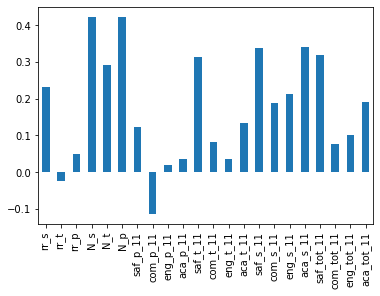

In [11]:
%matplotlib inline
combined.corr()['sat_score'][survey_fields].plot.bar()

There are high correlations between `N_s`, `N_t`, `N_p` and `sat_score`. Since these columns are correlated with `total_enrollment`, it makes sense that they would be high.

It is more interesting that `rr_s`, the student response rate, or the percentage of students that completed the survey, correlates with `sat_score`. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers percieved safety (`saf_t_11` and `saf_s_11`) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the `aca_s_11`, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for `aca_t_11`, how teachers perceive academic standards, or `aca_p_11`, how parents perceive academic standards.

## Exploring Safety and SAT Scores

Dig into this relationship a bit more, and try to figure out which schools have low safety scores.

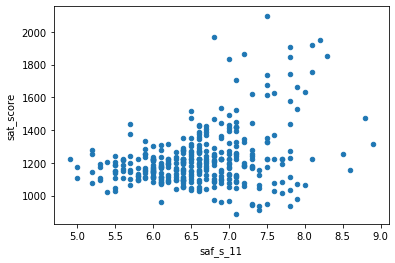

In [12]:
# making a scatter plot 

combined.plot.scatter(x='saf_s_11', y='sat_score')

Strong-ish positive correlation between `saf_s_11` and `sat_score`. The higher the students perceive safety at school, the higher the SAT score. Big cluster around lower perceived saftey and low SAT score. 


There appears to be a correlation between SAT scores and safety, although it isn't thatstrong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

/Users/Roya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()
/Users/Roya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


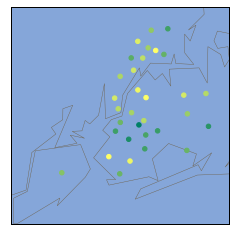

In [13]:
# Mapping out safety score
# Computing average safety score for each district.
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)

# Map showing safety scores by district
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plt

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

# Converting a pandas series to a list:
longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=districts['saf_s_11'], cmap='summer')
plt.show()


It looks like Upper Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas Brooklyn has low safety scores.

## Exploring Race and SAT Scores

There are a few columns that indicate the percentage of each race at a given school:

* `white_per`
* `asian_per`
* `black_per`
* `hispanic_per`

By plotting out the correlations between these columns and `sat_score`, we can determine whether there are any racial differences in SAT performance.

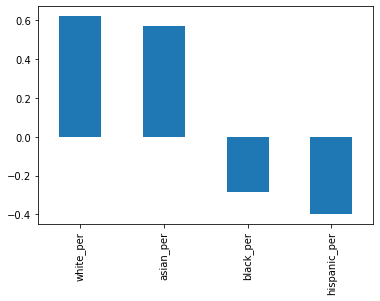

In [14]:
# racial differences in SAT scores.
race = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

combined.corr()["sat_score"][race].plot.bar()

Positive correlation between `white_per` and `asian_per` & `sat_score`. Negative correlation between `black_per` and `hispanic_per` and `sat_score`.


It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

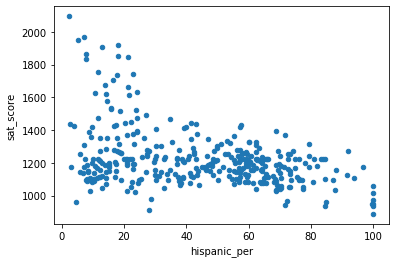

In [15]:
# exploring schools with low SAT scores and high hispanice_per

combined.plot.scatter(x='hispanic_per', y='sat_score')

The correlation score is based mainly around the cluster around low `hispanic_per` and `high sat_score`.

In [16]:
# Researching schools with hispanice_per greater than 95%

combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.


In [17]:
# Researching schools with hispanic_per < 10% and av.SAT score

combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

## Gender and SAT scores

There are two columns that indicate the percentage of each gender at a school:

* `male_per`
* `female_per`

We can plot out the correlations between each percentage and `sat_score`.

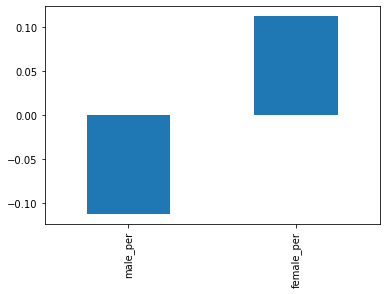

In [18]:
gender = ['male_per', 'female_per']

combined.corr()['sat_score'][gender].plot.bar()

It looks like a higher percentage of female students at a school correlates positively with sat score, whereas a higher percentage of male students correlates negatively with sat score.

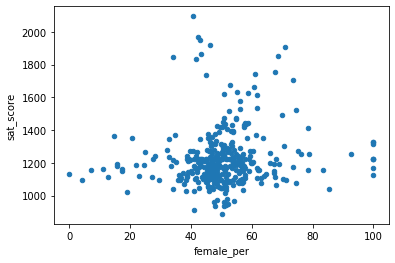

In [19]:
# Investigating schools with high SAT scores and high female_per

combined.plot.scatter(x='female_per', y='sat_score')


Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [20]:
# Schools with female_per > 60% and average SAT > 1700.

combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools appears to be very selective liberal arts schools that have high academic standards.

## AP scores vs SAT scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because `total_enrollment` is highly correlated with `sat_score`, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

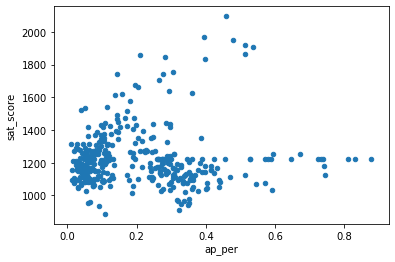

In [21]:
# percentage of students in each school that took an AP exam
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

# investigating relationship between AP scores and SAT scores
combined.plot.scatter(x='ap_per', y='sat_score')


It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.

# Next steps

* Determing wheter there's a correlation between class size and SAT scores
* Figuring out which neighborhoods have the best schools
    * If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.
* Investigating the differences between parent, teacher, and student responses to surveys.
* Assigning scores to schools based on `sat_score` and other attributes.


## Class size and SAT score

In [22]:
combined['AVERAGE CLASS SIZE'].head()

0    22.564286
1    22.231250
2    21.200000
3    23.571429
4    25.510526
Name: AVERAGE CLASS SIZE, dtype: float64

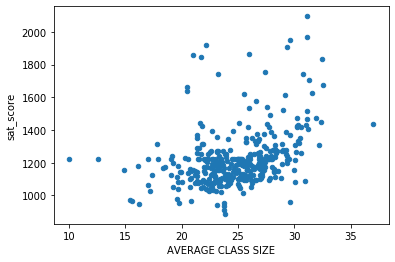

In [23]:
combined.plot.scatter(x='AVERAGE CLASS SIZE', y='sat_score')

Appears to be a weak positive correlation. The larger the average class size the higher the sat_score. There's a cluster/a majority of schools have an average class size between 20 to 30 students. 

In [24]:
# Schools with small class size (below 20) 

combined[combined['AVERAGE CLASS SIZE'] < 20] ['SCHOOL NAME']


6      47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...
8                                   ESSEX STREET ACADEMY
20            THE HIGH SCHOOL FOR LANGUAGE AND DIPLOMACY
35                                  VANGUARD HIGH SCHOOL
55          URBAN ASSEMBLY SCHOOL FOR MEDIA STUDIES, THE
56           THE URBAN ASSEMBLY SCHOOL FOR GREEN CAREERS
68                                 PARK EAST HIGH SCHOOL
83             HIGH SCHOOL FOR EXCELLENCE AND INNOVATION
91                   INTERNATIONAL COMMUNITY HIGH SCHOOL
106    PABLO NERUDA ACADEMY FOR ARCHITECTURE AND WORL...
108      HOLCOMBE L. RUCKER SCHOOL OF COMMUNITY RESEARCH
111                            BRONX BRIDGES HIGH SCHOOL
126                      BRONX INTERNATIONAL HIGH SCHOOL
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
188                   BROOKLYN INTERNATIONAL HIGH SCHOOL
208                              FRANCES PERKINS ACADEMY
238                           BROOKLYN GENERATION SCHOOL
243    HIGH SCHOOL FOR INNOVATI

Do some reasearch on the above schools

In [25]:
# Schools with high av. class size > 28 and sat score > 1700

combined[(combined['AVERAGE CLASS SIZE'] > 28) & (combined['sat_score'] > 1700)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
302                          TOWNSEND HARRIS HIGH SCHOOL
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Do some reasearch on the above schools

## Neighbourhoods with the best schools

Figuring out which neighborhoods have the best schools

If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.

In [26]:
# Computing average SAT score for each district.
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)

districts.head()


,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,Total Grads - % of cohort,...,priority09,priority10,Community Board,Council District,Census Tract,BIN,BBL,lat,lon,ap_per
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,71.333333,...,0.0,0.0,3.000000,1.500000,1106.833333,1.004144e+06,1.003302e+09,40.719022,-73.982377,0.192551
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,75.453574,...,0.0,0.0,4.204005,2.963296,1132.479744,1.103862e+06,1.070438e+09,40.739699,-73.991386,0.265711
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,74.029937,...,0.0,0.0,7.500000,6.500000,166.666667,1.034931e+06,1.012833e+09,40.781574,-73.977370,0.267818
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,76.257143,...,0.0,0.0,11.000000,8.000000,2637.000000,1.055874e+06,1.016681e+09,40.793449,-73.943215,0.246798
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,75.200881,...,0.0,0.0,9.428571,8.142857,9372.571429,1.063080e+06,1.019721e+09,40.817077,-73.949251,0.161767


In [27]:
districts[districts['sat_score'] > 1400]

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,Total Grads - % of cohort,...,priority09,priority10,Community Board,Council District,Census Tract,BIN,BBL,lat,lon,ap_per
21,22,473.5,502.75,474.25,1450.5,391.007212,614.509615,370.3625,580.25,86.325,...,0.0,0.0,12.75,45.0,633.5,3260954.25,3.071058e+09,40.618285,-73.952288,0.215706


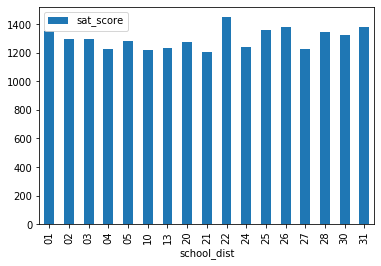

In [28]:
districts[districts['sat_score'] > 1200].plot.bar(x='school_dist', y='sat_score')

/Users/Roya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # This is added back by InteractiveShellApp.init_path()
/Users/Roya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


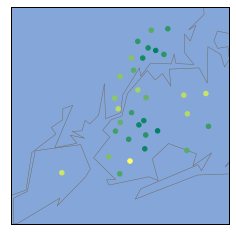

In [29]:
# Map showing sat_scores by district
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plt

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

# Converting a pandas series to a list:
longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=districts['sat_score'], cmap='summer')
plt.show()

/Users/Roya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/Users/Roya/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


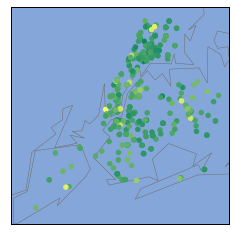

In [30]:
# Map showing sat_scores by school

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

# Converting a pandas series to a list:
longitudes = combined['lon'].tolist()
latitudes = combined['lat'].tolist()

m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=combined['sat_score'], cmap='summer')
plt.show()



## Investigating survey responses

Investigating the differences between parent, teacher, and student responses to surveys.

In [31]:
#Comparing overall survey scores by parent, teacher and student. Max total = 40

combined['parent_score'] =  combined['saf_p_11'] + combined['com_p_11'] + combined['eng_p_11'] + combined['aca_p_11']
parent_score = combined['parent_score'].mean()

combined['teacher_score'] =  combined['saf_t_11'] + combined['com_t_11'] + combined['eng_t_11'] + combined['aca_t_11']
teacher_score = combined['teacher_score'].mean()

combined['student_score'] =  combined['saf_s_11'] + combined['com_s_11'] + combined['eng_s_11'] + combined['aca_s_11']
student_score = combined['student_score'].mean()

print('parent:', parent_score)
print('teacher:', teacher_score)
print('student:', student_score)

parent: 31.126721763085396
teacher: 28.176859504132235
student: 26.708055555555564


Scores for each of the below factors were summed to give an overal score for the school by each group - parent, teacher and student: 
* Safety & respect 
* Communication
* Engagement
* Academic expectation

The maximum score is 40 for each school.

Students on average are more critical of their schools, giving a lower score overall. Parents are the least critical. 

(0, 10)

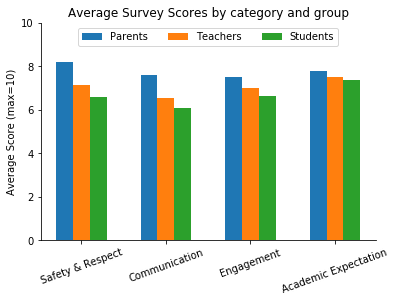

In [32]:
#Comparing survey scores for each factor by parent, teacher and student.

import numpy as np

labels = ['Safety & Respect', 'Communication', 'Engagement', 'Academic Expectation']
parent_means = [combined['saf_p_11'].mean(), combined['com_p_11'].mean(), combined['eng_p_11'].mean(), combined['aca_p_11'].mean()]
teacher_means = [combined['saf_t_11'].mean(), combined['com_t_11'].mean(), combined['eng_t_11'].mean(), combined['aca_t_11'].mean()]
student_means= [combined['saf_s_11'].mean(), combined['com_s_11'].mean(), combined['eng_s_11'].mean(), combined['aca_s_11'].mean()]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

# fig = plt.figure(figsize=(30,5))

fig, ax = plt.subplots()
bar1 = ax.bar(x - width, parent_means, width, label='Parents')
bar2 = ax.bar(x, teacher_means, width, label='Teachers')
bar3 = ax.bar(x + width, student_means, width, label='Students')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Score (max=10)')
ax.set_title('Average Survey Scores by category and group')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.tick_params(axis='x', rotation=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), ncol=3, fancybox=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim([0,10])

    

For all the different categories, students consistently score the schools lower than parents and teachers. 

## Overall score for schools

Assigning scores to schools based on sat_score and other attributes.

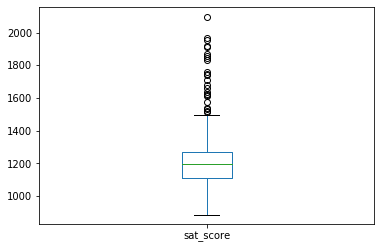

In [33]:
combined['sat_score'].plot.box()

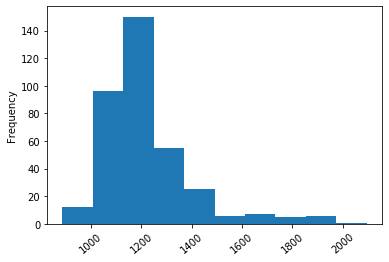

In [34]:
combined['sat_score'].plot(kind='hist', rot=40)

In [35]:
print(combined['sat_score'].max())
print(combined['sat_score'].min())

2096.0
887.0


Max score = 2400

Making the score system similar to surveys so can combine more easily so points will range from 0 to 10. Since no school scored lower than 887 or higher than 2100, will start scoring from between these numbers. 

NOTE: if this scoring system were to be used for other schools across America, the range would have to be from 0 to 2400. Since this scoring system is only being used for the dataset we have, can narrow down the range an apply it to scores of 0 to 10. 

2100-800 = 1300
1300/10 = 130

* 1 = 800 - 930
* 2 = 1060 
* 3 = 1190
* 4 = 1320
* 5 = 1450
* 6 = 1580
* 7 = 1710
* 8 = 1840
* 9 = 1970
* 10 = 2100


In [47]:
#Grouping sat_score into the above groups. 

combined['sat_group'] = combined['sat_score']

def grouping_sat_scores(val):
    if 800 <= val < 930:
        return 1
    elif 930 <= val < 1060:
        return 2
    elif 1060 <= val < 1190:
        return 3
    elif 1190 <= val < 1320:
        return 4
    elif 1320 <= val < 1450:
        return 5
    elif 1450 <= val < 1580:
        return 6
    elif 1580 <= val < 1710:
        return 7
    elif 1710 <= val < 1840:
        return 8
    elif 1840 <= val < 1970:
        return 9
    elif 1970 <= val < 2100:
        return 10
    
combined['sat_group'] = combined['sat_group'].apply(grouping_sat_scores)

combined['sat_group'].value_counts(dropna=False)

3     147
4     120
5      36
2      30
6       9
9       7
7       7
8       4
1       2
10      1
Name: sat_group, dtype: int64

In [48]:
combined[survey_fields].head()

,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,89.0,70,39,379.000000,26.0,151.0,7.8,7.7,7.4,7.6,...,6.1,6.5,6.000000,5.600000,6.100000,6.700000,6.7,6.2,6.6,7.0
1,84.0,95,10,385.000000,37.0,46.0,7.9,7.4,7.2,7.3,...,6.6,7.3,6.000000,5.700000,6.300000,7.000000,6.8,6.3,6.7,7.2
2,0.0,98,28,598.208333,42.0,150.0,8.7,8.2,8.1,8.4,...,8.0,8.8,6.611667,6.094722,6.620278,7.381389,7.9,7.9,7.9,8.4
3,90.0,100,21,306.000000,29.0,69.0,7.7,7.4,7.2,7.3,...,6.1,6.8,6.400000,5.900000,6.400000,7.000000,6.9,6.2,6.6,7.0
4,98.0,68,51,923.000000,67.0,736.0,8.5,7.9,7.9,8.4,...,5.9,7.3,7.300000,6.400000,7.000000,7.700000,7.8,6.7,6.9,7.8


(28, 38)

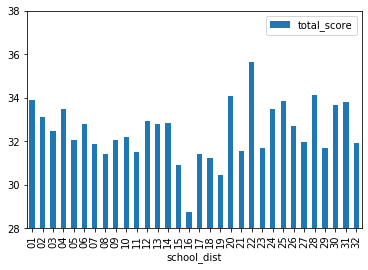

In [52]:
#Overall score of school by combining sat_scores along with survey scores
# Max score possible = 50 (sat groups, total survey scores (4) for each school )

combined['total_score'] = combined['saf_tot_11'] + combined['com_tot_11'] + combined['eng_tot_11'] + combined['aca_tot_11'] + combined['sat_group']

districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)

ax = districts.plot.bar(x='school_dist', y='total_score')
ax.set_ylim([28,38])